# Ruled-based Model

In this notebook, we elucidate how we developed a rule-based recommedation model to predict clothing items of bike commuters.This notebook covers the following steps: 

1. Importing libraries
2. Generating input data & collecting location and weather data from OpenWeatherMap API
3. Data pre-processing and exploratory data analysis
4. Model development 
5. Model evaluation
6. Model deployment
   
## 1. Importing libraries

In [98]:
import random
from random import randint
import requests, json
import pandas as pd
from datetime import datetime, timezone
import pytz # this lib allows accurate and cross platform timezone calculations with python
import numpy as np
import config # to run this, you should have the congif file in the working directory
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Generating input data & collecting location/weather data from OpenWeatherMap API

In the first step of this section, we define a function 'input_generator' by assinging values to variables

In [99]:
def input_generator():
    location_list=('Atlanta','Berlin','Hamburg','München','Freiburg','Melbourne', 'Moskau') # example list 
    location=location_list[randint(0,6)]
    time=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)# timezone is irrelevant for our objectives
    time=time.replace(hour=randint(time.hour,23))
    heaviness_of_trip=randint(1,3)
    if heaviness_of_trip==1: heaviness_of_trip="easy"
    if heaviness_of_trip==2: heaviness_of_trip="normal"
    if heaviness_of_trip==3: heaviness_of_trip="hard"
    heat_preference=randint(-5,5)
    sex=randint(1,3)
    if sex==1: sex="m"
    if sex==2: sex="f"
    if sex==3: sex="d"
    df=pd.DataFrame({
    "location" : [location],
    "time": [time], 
    "heaviness_of_trip": [heaviness_of_trip], 
    "heat_preference" : [heat_preference],
    "sex": [sex]
    })
    return df

In the next step, we define a function to generate multiple input data by iterating over rows and appending input data into the dataframe.

In [100]:
#auto-generating dataframe with multiple inputs
def generate_multi_input(a):
    df=input_generator()
    for t in range(a-1): #a Trips today (it is asking for one person, so the sex, the heat preference and the ocation ist not changing)
        df=df.append(input_generator(),ignore_index = True)
        df.at[t+1,'location']=df['location'].iloc[0]
        df.at[t+1,'heat_preference']=df['heat_preference'].iloc[0]
        df.at[t+1,'sex']=df['sex'].iloc[0]
    return df

In this step, we use python requests library to retrieve relevant data from the API. For this, we invoked the HTTP method Get to retrieve data.

In [101]:
def weather(df):
    base_url = "http://api.openweathermap.org/data/2.5/weather?" # assigning current weather url to base_url 
    future_url="https://api.openweathermap.org/data/2.5/forecast?"# assigning future weather url to future_url
    df['weather']=None
    df['temperature']=None
    #for every row in the dataframe
    for i in range(len(df.index)) :
        # Give city name
        city_name = df['location'].iloc[i]
        df_time=df['time'].iloc[i].replace(tzinfo=None)
        now=datetime.now(pytz.timezone('Europe/Berlin')).replace(tzinfo=None)
        # complete_url stores the api address for the current weather data
        complete_current_url = base_url + "appid=" + config.api_key + "&q=" + city_name + "&units=metric"
        # complete url stores the api address for the future weather data
        complete_future_url = future_url + "q=" + city_name + "&appid=" + config.api_key + "&units=metric"
        # expected response object
        response = requests.get(complete_current_url).json() #response of the current weather data
        response_future = requests.get(complete_future_url).json() # response of the future weather (3 hours weather forecast)
        time_forecast=datetime.strptime(response_future['list'][0]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        time_forecast2=datetime.strptime(response_future['list'][1]['dt_txt'],'%Y-%m-%d %H:%M:%S')
        # json method of response object
        # convert json format data into
        # python format data
        if (abs((df_time-now).total_seconds()) <abs((time_forecast-df_time).total_seconds()))&(abs((df_time-now).total_seconds()) <abs((time_forecast2-df_time).total_seconds())): #is the time closer to now then to any of the future forecast
            df.at[i,'weather']=response['weather'][0]['main']
            df.at[i,'temperature']=response['main']['temp']
            df.at[i,'windspeed']=response['wind']['speed']
        else:
            for a in range(10): # looks up to 30 hours in the future
                time_forecast=datetime.strptime(response_future['list'][a]['dt_txt'],'%Y-%m-%d %H:%M:%S')
                substrakt=time_forecast-df_time
                if abs(substrakt.total_seconds())<5400: ## Forecast is just every 3 hours, so it is always taking the closest one
                    df.at[i,'weather']=response_future['list'][a]['weather'][0]['main']
                    df.at[i,'temperature']=response_future['list'][a]['main']['temp']
                    df.at[i,'windspeed']=response_future['list'][a]['wind']['speed']
                    break   
    return df

The following function generates an evaluation dataset for a male user which is used for the evaluation of the model<p>

In [102]:
# generating dataset for different weather scenarios
def generate_evaluationset():
    df=input_generator()
    df.at[0,'heat_preference']=0
    df.at[0,'sex']='m'
    for t in range(14): # a trip for today (asking one person, thus, sex, the heat preference and the location isn't changing)
        df=df.append(input_generator(),ignore_index = True)
        df.at[t+1,'heat_preference']=0
        df.at[t+1,'sex']='m'
    return df

<hr style="border:2px solid gray"> </hr>   
   
## 3. Data pre-processing and exploratory data analysis (EDA)

We created a function that checks for missing values. If there is a missing value, it will return a string "incomplete data." This approach is pertinent to our case, for missing values are statistically significant in this model.

In [154]:
def input_cleaning(df):
    if df.isnull().sum().sum()==0:
        return "clean"
    return "incomplete_Data"

Getting summary statistics and visualising data by using histograms, box plots, bar charts and.

In [199]:
#creating a dataframe
df = weather(generate_evaluationset())
df

,location,time,heaviness_of_trip,heat_preference,sex,weather,temperature,windspeed
0,München,2022-02-04 20:00:14.967644,hard,0,m,Clouds,6.1,7.21
1,München,2022-02-04 13:00:14.970529,normal,0,m,Clouds,6.35,0.89
2,Hamburg,2022-02-04 23:00:14.976058,normal,0,m,Rain,2.7,6.22
3,Berlin,2022-02-04 18:00:14.980932,easy,0,m,Clouds,7.2,7.16
4,Berlin,2022-02-04 19:00:14.985193,hard,0,m,Clouds,7.2,7.16
5,München,2022-02-04 23:00:14.989132,normal,0,m,Clouds,5.15,7.74
6,Freiburg,2022-02-04 20:00:14.991966,easy,0,m,Clouds,5.06,3.69
7,Melbourne,2022-02-04 21:00:14.994494,easy,0,m,Clouds,24.68,5.50
8,Hamburg,2022-02-04 16:00:14.996963,easy,0,m,Clouds,8.13,7.71
9,Moskau,2022-02-04 19:00:14.999073,easy,0,m,Clouds,-10.78,1.43


In [201]:
#finding out the columns & their corresponding data types
df.dtypes

location                     object
time                 datetime64[ns]
heaviness_of_trip            object
heat_preference               int64
sex                          object
weather                      object
temperature                  object
windspeed                   float64
dtype: object

In [202]:
#converting the 'temperature' column from object to float
df = df.astype({"temperature":'float'}) 
display(df.dtypes)

location                     object
time                 datetime64[ns]
heaviness_of_trip            object
heat_preference               int64
sex                          object
weather                      object
temperature                 float64
windspeed                   float64
dtype: object

In [210]:
#summarising the numerical data by showing the shape of each attribute
df.describe()

,heat_preference,temperature,windspeed
count,15.0,15.000000,15.000000
mean,0.0,5.538667,5.178000
std,0.0,8.279631,2.406334
min,0.0,-10.780000,0.890000
25%,0.0,5.105000,3.815000
50%,0.0,6.360000,5.830000
75%,0.0,7.225000,7.160000
max,0.0,24.680000,7.740000


Thus, based on summary statistics of numerical data, we build histograms to get a feel for the shape of the distribution of the data

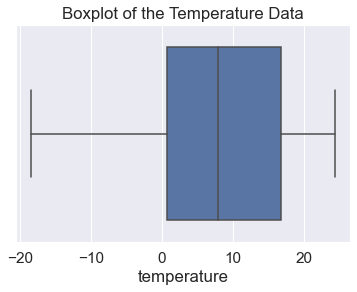

In [131]:
sns.boxplot(x = df["temperature"]).set_title("Boxplot of the Temperature Data")
plt.show()

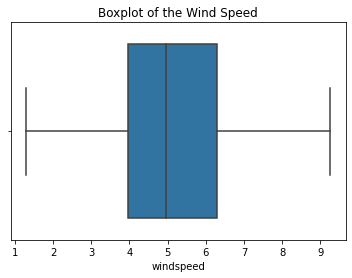

In [113]:
#creating a boxplot for all temperature data
sns.boxplot(x = df["windspeed"]).set_title("Boxplot of the Wind Speed")
plt.show()

<AxesSubplot:title={'center':'Frequency of Categories in the Weather'}, xlabel='weather', ylabel='Number of Occurrences'>

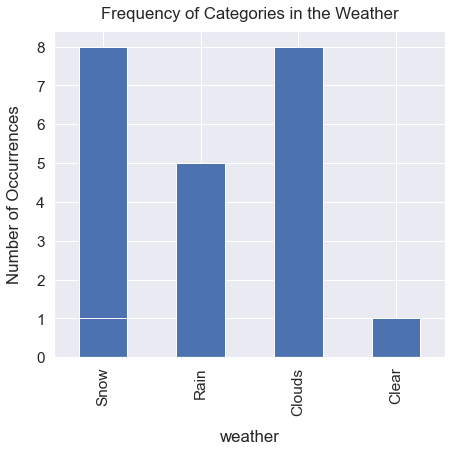

In [115]:
#creating a bar chart of frequency of the categories weather state variable
sns.set(font_scale=1.4)
df["weather"].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("weather", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in the Weather", y=1.02);
df["weather"].value_counts(sort=False).plot.bar()

<AxesSubplot:title={'center':'Frequency of Categories in Heaviness of Trip'}, xlabel='Heaviness of Trip', ylabel='Number of Occurrences'>

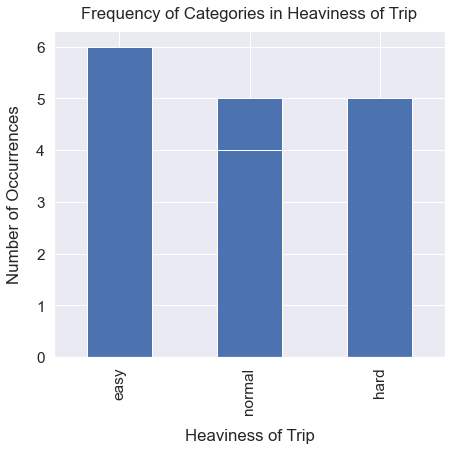

In [116]:
#creating a bar chart of frequency of the categories in heaviness of trip 
sns.set(font_scale=1.4)
df["heaviness_of_trip"].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Heaviness of Trip", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in Heaviness of Trip", y=1.02);
df["heaviness_of_trip"].value_counts(sort=False).plot.bar()

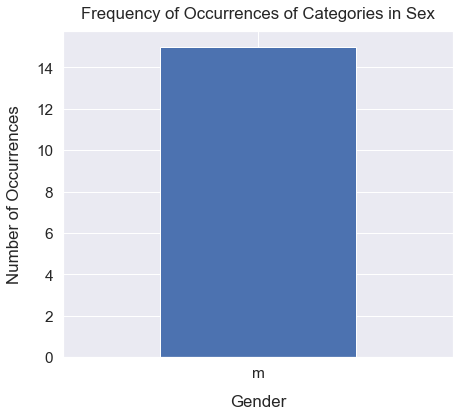

In [204]:
#creating a bar chart of frequency of the categories in sex
sns.set(font_scale=1.4)
df['sex'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Gender", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Occurrences of Categories in Sex", y=1.02);


The bar chart is displaying only one category, because the dataset was generated for a male user.

<hr style="border:2px solid gray"> </hr>   
   
## 4. Model development

In this section, we develop a model, based on the rules extracted from decision trees. The rules define the clothing items for different bodyparts based on five distinct features. We took the following arithmetic expression 'temp + heatperception – (if female ==2) > current_temp' as the main logic. The thresholds were picked based on empirical observation (personal experience) and intuition. All functions use dataframes as input and append new columns by extending the frame.<p>
The exhaustive logic of decision trees can be found [here](https://drive.google.com/file/d/1x186bn4po5ubpvwio5aLXn5z5fHepdLz/view?usp=sharing).

In [ ]:
def t_p_s_h(df,i): # t_p_s_h stands for temperature_heat preference_sex_heaviness_of_trip
    red=0. # reducing parameter
    if df['sex'].iloc[i]=='f':
        red=2.
    heaviness=0.
    if df['heaviness_of_trip'].iloc[i]=='hard':
        heaviness=2.
    else:
        if df['heaviness_of_trip'].iloc[i]=='easy':
            heaviness=-2.
    t_p_s_h=float(df['temperature'].iloc[i])+float(df['heat_preference'].iloc[i])-red+heaviness
    return t_p_s_h

In [ ]:
# defining the rules for headwear
def headwear(df):
   df['headwear']=3
   for i in range(len(df.index)):
      if t_p_s_h(df,i)>10: # if temp above 10C, the model recommends nothing but Helmet
            df.at[i,'headwear']=1
      else:
         if t_p_s_h(df,i)>2:
            df.at[i,'headwear']=2
   return df

In [ ]:
# defining the rules for sunglasses
def sunglasses(df):
    df['sunglasses']=0
    for i in range(len(df.index)):
        if df['weather'].iloc[i]=='Clear': # sun or clear is the only split for this tree
            df.at[i,'sunglasses']=1
    return df

In [ ]:
# defining the rules for neck
def neck(df):
    
    df['neck']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # above 22 degrees no buff
            df.at[i,'neck']=1
        else :
            if t_p_s_h(df,i)>12:
                if (df['weather'].iloc[i]=='Rain')|(df['windspeed'].iloc[i]>15): # if temp > 15C & windy or rainy, then buff, else none.
                    df.at[i,'neck']=2
                else :
                    df.at[i,'neck']=1
            else :
                if (t_p_s_h(df,i)>0) | (df['weather'].iloc[i]=='Clear'): # if temp > 0C & sunny, then buff, otherwise warm scarf
                    df.at[i,'neck']=2
    return df

In [ ]:
# defining the rules for shirt and singlet 
def inner_layer(df):
    df['shirt']=0
    df['singlet']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>10: # 10 C is the split. If temp is above 10, wear shirt. Under 10C wear a singlet.
            df.at[i,'shirt']=1
        else:
            df.at[i,'singlet']=1
    
    return df

In [ ]:
#defining the rules for the upper body clothing pieces
def upper_body_outer_layers(df):
    df['upper_body_second_layer']=3
    df['upper_body_third_layer']=3
    df['upper_body_outer_layer']=5
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>25:
            df.at[i,'upper_body_second_layer']=1
            df.at[i,'upper_body_third_layer']=1
            df.at[i,'upper_body_outer_layer']=1
        else:
            if t_p_s_h(df,i)>20:
                if df['weather'].iloc[i]=='Rain':
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=3
                else:
                    df.at[i,'upper_body_second_layer']=2
                    df.at[i,'upper_body_third_layer']=1
                    df.at[i,'upper_body_outer_layer']=1
            else:
                if t_p_s_h(df,i)>10:
                    if df['weather'].iloc[i]=='Rain':
                        df.at[i,'upper_body_second_layer']=3
                        df.at[i,'upper_body_third_layer']=1
                        df.at[i,'upper_body_outer_layer']=4
                    else:
                        df.at[i,'upper_body_second_layer']=2
                        df.at[i,'upper_body_third_layer']=2
                        df.at[i,'upper_body_outer_layer']=1
                else:
                    if t_p_s_h(df,i)>0:
                        if df['weather'].iloc[i]=='Clear':
                            df.at[i,'upper_body_second_layer']=2
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
                        else:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=1
                            df.at[i,'upper_body_outer_layer']=5
                    else:
                        if t_p_s_h(df,i)>-5:
                            df.at[i,'upper_body_second_layer']=3
                            df.at[i,'upper_body_third_layer']=2
                            df.at[i,'upper_body_outer_layer']=3
    return df

In [ ]:
#defining the rules for handwear
def hands(df):
    df['hands']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>15: # first split is at 10 C, model recommends no handwear.
            df.at[i,'hands']=1
        else:
            if (t_p_s_h(df,i)>11):
                if(df['windspeed'].iloc[i]>15):
                    df.at[i,'hands']=2
                else:
                    df.at[i,'hands']=1
            else:
                if (t_p_s_h(df,i)>8):
                    df.at[i,'hands']=2
    return df

In [ ]:
# defining the rules for raintrousers
def raintrousers(df):
    df['raintrousers']=0
    for i in range(len(df.index)):
        if t_p_s_h(df,i)<17: # 17C is the first split. If temp < 17 and rainy, it recommends raintrousers.
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'raintrousers']=1
    return df

In [ ]:
# defining the rules for socks
def socks(df):
    df['socks']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22: # if temp > 22 and rainy, the model recommends socks
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'socks']=2
            else:
                if df['sex'].iloc[i]=='f': # if temp > 22, weather state is not rainy & user is female, then no socks, for male with socks
                    df.at[i,'socks']=1
                else:
                    df.at[i,'socks']=2
        else:
            if t_p_s_h(df,i)>0:       # above 0 normal socks, under 0 woolen socks
                df.at[i,'socks']=2
    return df

In [ ]:
#defining the rules for shoes
def shoes(df):
    df['shoes']=3
    for i in range(len(df.index)):
        if t_p_s_h(df,i)>22:   # if the temp > 22 C & rainy, the model recommends low shoes
            if df['weather'].iloc[i]=='Rain':
                df.at[i,'shoes']=2
            else:
                    df.at[i,'shoes']=1 # if temp > 22, the model recommends summer shoes
        else:
            if t_p_s_h(df,i)>2: # if temp > 7 & rainy, the model recommends rainshoes
                if df['weather'].iloc[i]=='Rain':
                    df.at[i,'shoes']=4 # if not rainy, then normal shoes. if under 7 C, then boots
                else:
                    df.at[i,'shoes']=2

    return df

In [ ]:
# concatenating the output of the logic of the decision trees into single list
def get_clothing_output_rbm(df):
    headwear(df)
    sunglasses(df)
    neck(df)
    inner_layer(df)
    upper_body_outer_layers(df)
    hands(df)
    raintrousers(df)
    socks(df)
    shoes(df)
    #df['control']=0
    #for i in range(len(df.index)):
    #   df.at[i,'control']=t_p_s_h(df,i)
    return df

In [ ]:
# using function 'add_dummy(df)'for testing purposes.<p>
def add_dummy(df):
    df['headwear']=1
    df['sunglasses']=0
    df['neck']=1
    df['singlet']=0
    df['shirt']=0
    df['upper_body_second_layer']=1
    df['upper_body_third_layer']=1
    df['upper_body_outer_layer']=1
    df['hands']=1
    df['raintrousers']=0
    df['socks']=1
    df['shoes']=1
    for i in range(len(df.index)):
        df.at[i,'headwear']=randint(1,4)
        df.at[i,'sunglasses']=randint(0,1)
        df.at[i,'neck']=randint(1,3)
        df.at[i,'singlet']=randint(0,1)
        df.at[i,'shirt']=randint(0,1)
        df.at[i,'upper_body_second_layer']=randint(1,3)
        df.at[i,'upper_body_third_layer']=randint(1,3)
        df.at[i,'upper_body_outer_layer']=randint(1,5)
        df.at[i,'hands']=randint(1,3)
        df.at[i,'raintrousers']=randint(0,1)
        df.at[i,'socks']=randint(1,2)
        df.at[i,'shoes']=randint(1,3)
    return df

<hr style="border:2px solid gray"> </hr>  

## 5. Model evaluation

- Evaluation from technical perspective:
We generated fifteen different weather scenarios (combination of six features) for hot, warm, breezy, and cold seasons to ask a user to fill in the table with clothing pieces that s/he would pick for given scenarios. We compared a user’s clothing selections with clothing recommendations from the rule-based model. The model scored 73% (double check), outperforming our initial prediction accuracy score goal for three percent. 
 
- Evaluation from user's point of view:
Afterward, we provided a user with clothing predictions from the rule-based model to evaluate the recommendations on a scale of way too cold’, ‘a little too cold’, ‘just right’, ‘a little too hot’, ‘way too hot’. The successful model will achieve a perfect clothing feedback score of above 70% of app uses (still needs to be conducted).

In [ ]:
#generating an evaluation set for user to fill out
evaluation_technical=weather(generate_evaluationset())
#comparing user-chosen clothing items to given scenarios to clothing outputs recommended by rule-based model
evaluation_user=get_clothing_output_rbm(evaluation_technical)
evaluation_user.to_csv('evaluation_user_csv_v1.csv')# saving the evaluation set into a csv file

In [ ]:
#reading the evaluationset with Matze's data and creating a dataframe with input data from the evaluation set
matze=pd.read_csv('evaluation_user_matze.csv', sep=";")
matze
matze_input=matze.iloc[: , :8]
matze_input['heat_preference']=0
matze_input

The following code goes through the filled out evaluation set and attempts to find the optimal heat preference.

In [ ]:
sco={}
score_df=pd.DataFrame.from_dict(sco)
score_df['score']=0
for i in range(-5,6):
    matze_input['heat_preference']=i
    comp=get_clothing_output_rbm(matze_input).compare(matze,keep_shape=True)
    comp=comp.loc(axis=1)[:,'self']
    comp.columns=comp.columns.droplevel(-1)
    comp.drop('heat_preference',axis=1, inplace=True)
    score=1-(comp.notna().sum().sum())/180
    score_df.at[i,'score']=score
    print('the heatpreference is: ', i , ' the score is: ', score)
#comp
#score
#print(score_df)
score_df.plot(drawstyle='steps')
plt.xlabel("heat_preference")
plt.title('scoring for the recommendation ouput on Matzes Evaluation data depending on the heat_preference')
plt.show()

The following lines are manly to understand the usage with the dataframe and to find out how to plot the data

In [ ]:
matze_input['heat_preference']=1
best=get_clothing_output_rbm(matze_input).compare(matze,keep_shape=True)
#print(best)
best=best.loc(axis=1)[:,'self']
best.columns=best.columns.droplevel(-1)
best.drop('heat_preference',axis=1, inplace=True)
best.drop(columns=['location','time','heaviness_of_trip','sex','weather','temperature','windspeed'], inplace=True)
best_wrong=best.notna().sum().sum() # counting the wrongs
score=1-best_wrong/180
#print(score)
#print(best.notna().sum().sort_values())
#best.columns


The bar chart that displays the number of wrong recommendations per category

In [97]:
fig, axs = plt.subplots(1, 1, figsize=(20, 4), sharey=True)
plt.bar(best.columns,best.notna().sum())
plt.xticks(rotation=90)
axs.title('number of wrong recommendations')
best.notna().sum().sort_values().plot(drawstyle="bar", linewidth=2, title='number of wrong recommendations')
plt.title('number of wrong recommendations per category')
plt.show()

Showing a bar with the percantage of correct recommendations per category

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(20, 4), sharey=True)
plt.bar(best.columns,(1-(best.notna().sum()/15)))
for i, v in enumerate((1-(best.notna().sum()/15))):
    axs.text(i, v, str(round(v*100,2))+"%", 
            color = 'blue')
plt.xticks(rotation=90)
#axs.title('number of wrong recommendations')
#best.notna().sum().sort_values().plot(drawstyle="bar", linewidth=2, title='number of wrong recommendations')
plt.title('number of correct recommendations per category in %')
plt.show()

## Interpretation of evaluation bar charts
The primary cause of relatively high wrong recommendation score is the user's idiosyncratic clothing choice habits.
The followings are the elucidations of the reasons behind the largest number of false recommendations.

1. The shoes class has the highest wrong recommendation score due to the fact that the user wears the same type of shoes for almost all seasons, whereas our model recommends different shoe-types for winter, summer and autumn seasons.

2. The primary cause of high wrong recommendation score for neck(class) is the user's preference to wear buff for colder weather conditions and wear nothing for warmer ones. Initially, the model recommended woolen scarf for colder weather conditions, but after gaining more insights from a user perspective, we adjusted the thresholds to recommend 'buff' for wide temperature range. 
3. Shirt and singlet are tricky to predict in general.Some prefer singlet, some never wears it. It varies from individual to individual and thus, difficult to implement one logic here.
4. The user who participated in evaluation survey does not wear sunglasses.
5. The score on the outer layer is better than expected. Since we always recommend a set of the 3 layers, personal preferences can also vary in chosing how many layers and which type of upper clothing to wear. For example, if you decide not to wear anything in the second layer, consequently, it will have a big impact on the third and outer layers.

<hr style="border:2px solid gray"> </hr>  

## 6. Model deployment

The output of the rule-based model was deployed with [Flask API](https://github.com/TechLabs-Berlin/wt21-commfy/blob/main/DS_Files/Flask_api.py) on PythonAnywhere server.


Output concatenation: the function 'get_clothing(df)' outputs 3 recommendations in dataframes. 

- The first df recommends clothing items for current enquiry
- The second df recommends which clothing items to pack in a backpack
- The third one provides information on what to wear at which trip.

The functions recommendation_df(df)& recommendation_json(js) converts the input (either from a df or a json) into a json format required for the Flask API.

In [ ]:
# get three lists for to wear now and to bring in the backpack and a full DF what to wear at which trip
def get_clothing(df):
    dic=['headwear','sunglasses','neck','singlet','shirt','upper_body_second_layer','upper_body_third_layer','upper_body_outer_layer','hands','raintrousers','socks','shoes'] # all columns
    oneisnone=['headwear','neck','upper_body_second_layer','upper_body_third_layer','upper_body_outer_layer','hands'] # all colums where 1 is the lowest possible output
    ##wear_now is the first clothing set from the first input beside when shoes and jacket are to big, they have to be wear them 
    wear_now=df.iloc[0:1].copy()
    ##in the backpack is all the other necessary clothes
    backpack_help=df.iloc[:,8:].copy()
    backpack=backpack_help.iloc[0:0].copy() # empty DF with column names
    for i in dic:
        if backpack_help[i].unique().max()==0|((i in oneisnone) & backpack_help[i].unique().max()==1): #if the maximum of the category is not wear any, stop here
            backpack.at[0,i]=None
        else:
            z=0
            while z<backpack_help[i].nunique():
                if backpack_help[i].unique()[z]!=0: #if the the newest item of the category is not to wear any, skip it
                    if ((i in oneisnone) & backpack_help[i].unique()[z]!=1):
                        backpack.at[z,i]=backpack_help[i].unique()[z]
                z=z+1
    ##if shoes or the outerlayer are bigger in the backpack we gonna wear the biggest one, so the backpack won't get to full
    if backpack_help['shoes'].unique().max()> wear_now['shoes'][0]:
        wear_now.at[0,'shoes']=backpack_help['shoes'].unique().max()
    backpack.at[:,'shoes']=None
    if backpack_help['upper_body_outer_layer'].unique().max()> wear_now['upper_body_outer_layer'][0]:
        wear_now.at[0,'upper_body_outer_layer']=backpack_help['upper_body_outer_layer'].unique().max()
    backpack.at[:,'upper_body_outer_layer']=None  
    backpack=backpack.replace({np.nan: None})
    #Ouput of all Clothing Sets in every trip, shoes and outerlayer must be the same as in the first trip
    clothing_per_trip=df
    clothing_per_trip.at[:,'shoes']=wear_now['shoes'][0]
    clothing_per_trip.at[:,'upper_body_outer_layer']=wear_now['upper_body_outer_layer'][0]

    return wear_now, backpack, clothing_per_trip


In [ ]:
def recommendation_json(js):
    json_inp= pd.read_json(js, orient='index',convert_dates=['time'])  
    if input_cleaning(json_inp)=='incomplete_Data':
        return 'incomplete_Data'
    else:
        rec_dfs = get_clothing(get_clothing_output_rbm(weather((json_inp))))
        rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
        rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json() # drop the nan from df
        rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
        return rec_js

In [ ]:
def recommendation_df(df):
    if input_cleaning(df)=="incomplete_Data":
        return "incomplete_Data"
    else:
        rec_dfs = get_clothing(get_clothing_output_rbm(weather(df)))
        rec_js= '{"clothes":{"now":'+rec_dfs[0].to_json(orient="records")
        rec_js= rec_js+',"backpack":'+rec_dfs[1].apply(lambda x: [x.dropna()], axis=1).to_json()#(orient="columns")
        rec_js= rec_js+',"perTrip":'+rec_dfs[2].to_json(orient="index")+'}}'
        return rec_js

<hr style="border:2px solid gray"> </hr>  

## Testing area

In [ ]:
#checking if the function is working as defined
a=generate_multi_input(4)
print(a)
#displaying data in json
a=a.to_json(orient="index",date_format='iso')
print(a)
#testing data with json input
json_inp=pd.read_json(a, orient='index',convert_dates=['time'])   
print(json_inp)
#testing the read in from different jsn formats
b={"0":{"location":"Freiburg"},"1":{"time":"2022-01-23T23:09:32.856Z"},"2":{"location":"Freiburg","time":"2022-01-23T22:09:32.867Z","heaviness_of_trip":"easy","heat_preference":-2,"sex":"m"},"3":{"location":"Freiburg","time":"2022-01-23T17:09:32.878Z","heat_preference":-2,"sex":"m"}}
c=json.dumps(b)
print(c)
json_inp= pd.read_json(c, orient='index',convert_dates=['time'])   
print(json_inp)

In [ ]:
#testing two weather dataframes (one with just 1 input, and one with 6 input with trips)
test=weather(input_generator())
len(test.index)
test.to_json()
print(test.to_json())
print(test)
test2=weather(generate_multi_input(20))
test2.head()

In [ ]:
#testing the input cleaner
print(input_cleaning(json_inp))
print(json_inp)
recommendation_df(json_inp)

In [ ]:
#testing the model
test3=weather(generate_multi_input(20))
get_clothing_output_rbm(test3)